CNN Implementation

I am using Pytorch built In dataset.

Dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/

We have created a 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.


Total Images: 3680

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Dataset loading
train_dataset = OxfordIIITPet(root='datasets/', split='trainval', target_types='category',
                              download=True, transform=transform_train)
val_dataset = OxfordIIITPet(root='datasets/', split='test', target_types='category',
                            download=True, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=4, pin_memory=True)


In [3]:
import torch
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


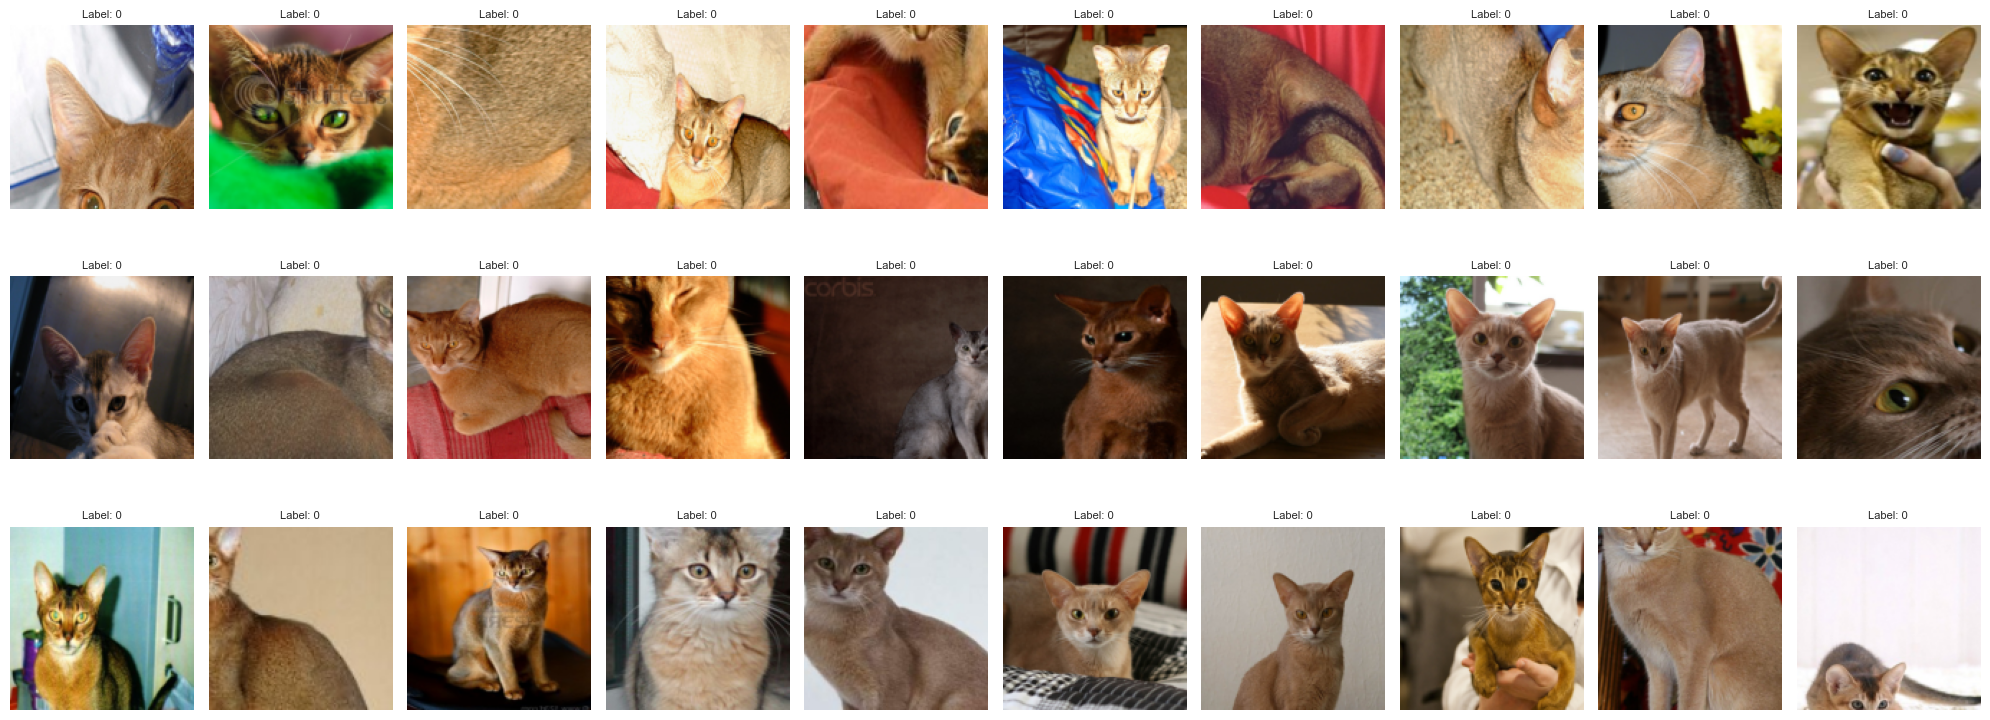

In [27]:
import matplotlib.pyplot as plt

# Set up a 3x10 grid
fig, axes = plt.subplots(3, 10, figsize=(20, 8))

for idx in range(30):
    image, label = train_dataset[idx]
    ax = axes[idx // 10, idx % 10]  # 3 rows, 10 columns

    # Convert CHW to HWC and unnormalize if needed
    image = image.permute(1, 2, 0)  # CHW → HWC
    image = image * 0.5 + 0.5  # Assuming images are normalized in [-1, 1]
    image = image.clamp(0, 1)  # Ensure values are within [0, 1]

    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Label: {label}", fontsize=8)

plt.tight_layout()
plt.show()


In [5]:
# CNN Model
class CNN(nn.Module):
    def __init__(self, output=37):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),     # 128x128
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                    # 64x64

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                    # 32x32

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                    # 16x16

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))        # 1x1
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, output)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.classifier(x)
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()   

Training and Evaluation

In [6]:
# Training loop with accuracy
def evaluate(loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
    return loss_sum / total, 100. * correct / total

for epoch in range(1, 5):
    model.train()
    total_loss = 0.0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_train += images.size(0)

    train_loss = total_loss / total_train
    val_loss, val_acc = evaluate(val_loader)

    print(f"Epoch {epoch}/50 - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")


Epoch 1/50 - Train Loss: 3.5678 | Val Loss: 3.5390 | Val Acc: 6.24%
Epoch 10/50 - Train Loss: 3.1515 | Val Loss: 3.5278 | Val Acc: 9.40%
Epoch 20/50 - Train Loss: 2.8013 | Val Loss: 3.1767 | Val Acc: 14.50%
Epoch 30/50 - Train Loss: 2.5419 | Val Loss: 3.1914 | Val Acc: 16.14%
Epoch 40/50 - Train Loss: 2.3854 | Val Loss: 3.2831 | Val Acc: 15.64%
Epoch 50/50 - Train Loss: 2.2288 | Val Loss: 2.8041 | Val Acc: 27.06%



pretrained ResNet18 and freeze parameters

In [18]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, alexnet
from torch.optim import Adam

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18 and freeze parameters
model_ft = resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

# Replace the final layer for 37 classes and move model to device
model_ft.fc = nn.Linear(model_ft.fc.in_features, 37)
model_ft = model_ft.to(device)

# Define loss function and optimizer (only train fc layer)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_ft.fc.parameters(), lr=0.001)

# Evaluation function
def evaluate(loader):
    model_ft.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_ft(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
    return loss_sum / total, 100. * correct / total

# Training loop
for epoch in range(5):
    model_ft.train()
    total_loss = 0.0
    total_train = 0

    for images, labels in train_loader:  # Make sure train_loader is defined
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_train += images.size(0)

    train_loss = total_loss / total_train
    val_loss, val_acc = evaluate(val_loader)  # Make sure val_loader is defined

    print(f"Epoch {epoch+1}/5 - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

Epoch 1/5 - Train Loss: 2.5868 | Val Loss: 1.6708 | Val Acc: 57.84%
Epoch 2/5 - Train Loss: 1.4431 | Val Loss: 1.2940 | Val Acc: 64.35%
Epoch 3/5 - Train Loss: 1.1736 | Val Loss: 1.1752 | Val Acc: 66.26%
Epoch 4/5 - Train Loss: 1.0442 | Val Loss: 1.0867 | Val Acc: 68.17%
Epoch 5/5 - Train Loss: 0.9719 | Val Loss: 1.0202 | Val Acc: 69.61%


pretrained alexnet and freeze parameters

In [24]:
import torch
import torch.nn as nn
from torchvision.models import alexnet
from torch.optim import Adam

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_alex = alexnet(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
    
model_alex.classifier[6] = nn.Linear(model_alex.classifier[6].in_features, out_features = 37)
model_alex = model_alex.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_alex.classifier[6].parameters(), lr=0.001)

# Evaluation function
def evaluate(loader):
    model_alex.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_alex(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
    return loss_sum / total, 100. * correct / total

# Training loop
for epoch in range(5):
    model_alex.train()
    total_loss = 0.0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_alex(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_train += images.size(0)

    train_loss = total_loss / total_train
    val_loss, val_acc = evaluate(val_loader)

    print(f"Epoch {epoch+1}/5 - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")


Epoch 1/5 - Train Loss: 2.2991 | Val Loss: 1.9040 | Val Acc: 46.91%
Epoch 2/5 - Train Loss: 1.5836 | Val Loss: 1.8795 | Val Acc: 48.54%
Epoch 3/5 - Train Loss: 1.4248 | Val Loss: 1.9159 | Val Acc: 47.48%
Epoch 4/5 - Train Loss: 1.3014 | Val Loss: 1.9321 | Val Acc: 48.76%
Epoch 5/5 - Train Loss: 1.2534 | Val Loss: 1.9514 | Val Acc: 48.81%


Comparison with MLP (ANN)

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, output_size)

        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
model_ann = NeuralNet(input_size=128*128*3, output_size=37)
optimizer = torch.optim.Adam(model_ann.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [4]:
# Training loop with accuracy
def evaluate(loader):
    model_ann.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_ann(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
    return loss_sum / total, 100. * correct / total

for epoch in range(1, 6):
    model_ann.train()
    total_loss = 0.0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ann(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_train += images.size(0)

    train_loss = total_loss / total_train
    val_loss, val_acc = evaluate(val_loader)

    print(f"Epoch {epoch}/5 - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")


Epoch 1/5 - Train Loss: 3.6223 | Val Loss: 3.5985 | Val Acc: 4.14%
Epoch 2/5 - Train Loss: 3.5710 | Val Loss: 3.5329 | Val Acc: 5.12%
Epoch 3/5 - Train Loss: 3.5420 | Val Loss: 3.4993 | Val Acc: 5.72%
Epoch 4/5 - Train Loss: 3.5118 | Val Loss: 3.5332 | Val Acc: 6.70%
Epoch 5/5 - Train Loss: 3.5085 | Val Loss: 3.4989 | Val Acc: 5.61%
